PicoScope 2000A device connected successfully.

Acquiring 1250000 samples over 0.0050 seconds...

--- Acquisition Details ---
Actual sampling interval: 4.00 ns (250.00 MS/s)
Number of samples acquired: 1250000
Voltage range: +/- 1000 mV
Applied Voltage: 67.9 V
Temperature: 10.0 °C
---------------------------

Signal data saved to: picoscope_recordings\picoscope_signal_20250610_163141.npy
Metadata saved to: picoscope_recordings\picoscope_signal_20250610_163141_metadata.json


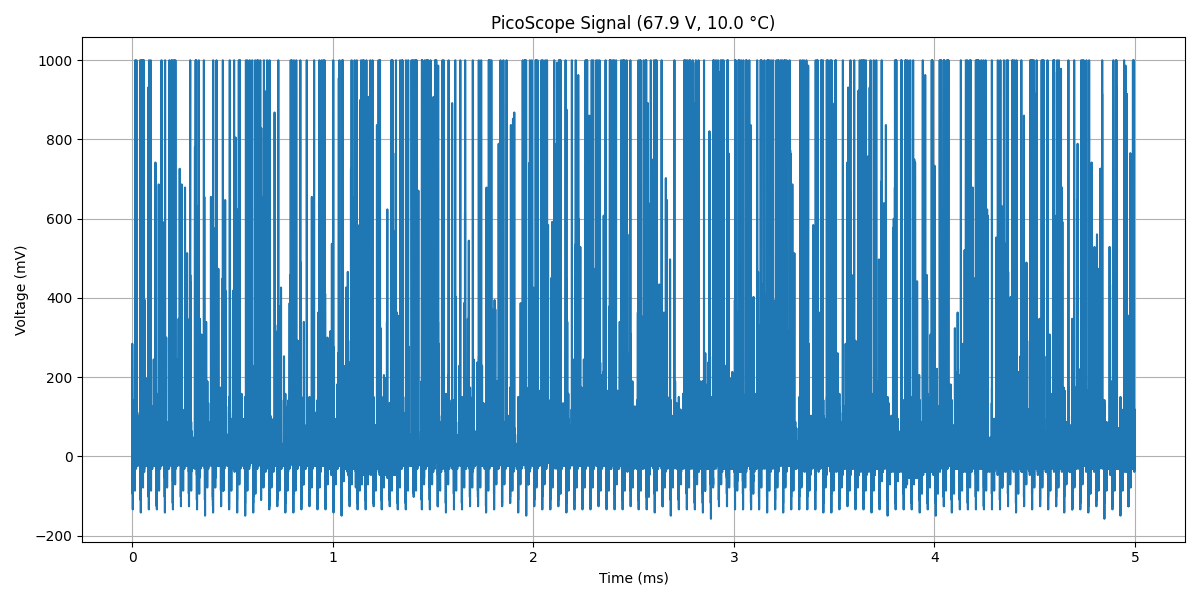

PicoScope unit closed.


In [ ]:
import ctypes
import numpy as np
from picosdk.ps2000a import ps2000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok
import time
import os
import json # For saving metadata

# --- Configuration for Data Saving ---
OUTPUT_FOLDER = "picoscope_recordings"
# Ensure the output directory exists before any file operations
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"Created folder: {OUTPUT_FOLDER}")

def check_picoscope_connection():
    """Checks if a PicoScope 2000A device can be opened."""
    chandle = ctypes.c_int16()
    try:
        status = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
        assert_pico_ok(status)
        if status == 0:
            print("PicoScope 2000A device connected successfully.")
            return chandle
        else:
            print(f"PicoScope 2000A device connection failed. Status code: {status}")
            return None
    except Exception as e:
        print(f"Error connecting to PicoScope 2000A: {e}")
        return None

def setup_channel(chandle, channel, enabled, coupling, range_mv, offset_v=0.0):
    """Sets up a PicoScope channel."""
    range_code = None
    ranges_mv = {
        10: ps.PS2000A_RANGE['PS2000A_10MV'],
        20: ps.PS2000A_RANGE['PS2000A_20MV'],
        50: ps.PS2000A_RANGE['PS2000A_50MV'],
        100: ps.PS2000A_RANGE['PS2000A_100MV'],
        200: ps.PS2000A_RANGE['PS2000A_200MV'],
        500: ps.PS2000A_RANGE['PS2000A_500MV'],
        1000: ps.PS2000A_RANGE['PS2000A_1V'],
        2000: ps.PS2000A_RANGE['PS2000A_2V'],
        5000: ps.PS2000A_RANGE['PS2000A_5V'],
        10000: ps.PS2000A_RANGE['PS2000A_10V'],
        20000: ps.PS2000A_RANGE['PS2000A_20V']
    }
    if range_mv in ranges_mv:
        range_code = ranges_mv[range_mv]
    else:
        print(f"Warning: {range_mv} mV range not directly supported. Using closest available.")
        closest_range = min(ranges_mv.keys(), key=lambda x: abs(x - range_mv))
        range_code = ranges_mv[closest_range]
        range_mv = closest_range
        print(f"Using {range_mv} mV range (code: {range_code}).")

    status = ps.ps2000aSetChannel(chandle,
                                   channel,
                                   enabled,
                                   coupling,
                                   range_code,
                                   offset_v)
    assert_pico_ok(status)
    return range_code, range_mv

def acquire_block_data(chandle, num_samples, timebase):
    """Acquires a block of data from the PicoScope."""
    buffer_max = (ctypes.c_int16 * num_samples)()
    buffer_min = (ctypes.c_int16 * num_samples)()
    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']

    status_set_buffers = ps.ps2000aSetDataBuffers(chandle, channel_a, ctypes.byref(buffer_max), ctypes.byref(buffer_min), num_samples, 0, 0)
    assert_pico_ok(status_set_buffers)

    status_run_block = ps.ps2000aRunBlock(chandle, 0, num_samples, timebase, 0, None, 0, None, None)
    assert_pico_ok(status_run_block)

    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0)
    while ready.value == check.value:
        is_ready = ps.ps2000aIsReady(chandle, ctypes.byref(ready))
        if is_ready != 0:
            print(f"Error checking readiness: {is_ready}")
            break
        time.sleep(0.001)

    overflow = ctypes.c_int16()
    c_num_samples = ctypes.c_int32(num_samples)
    status_get_values = ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_num_samples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status_get_values)

    return buffer_max

def main():
    """Records a PicoScope signal, asks for metadata, and saves it."""
    chandle = check_picoscope_connection()
    if chandle is None:
        return

    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
    enabled = 1
    coupling = ps.PS2000A_COUPLING['PS2000A_DC']
    voltage_range_mv = 1000 # Default range, can be adjusted
    
    # --- User Input for Metadata ---
    try:
        applied_voltage = float(input("Enter the applied voltage (V): "))
        temperature_celsius = float(input("Enter the temperature (°C): "))
    except ValueError:
        print("Invalid input for voltage or temperature. Please enter numbers.")
        if chandle:
            ps.ps2000aCloseUnit(chandle)
        return

    # --- Acquisition Parameters ---
    # You might want to make these configurable or calculate based on desired time/samples
    acquisition_duration_s = 0.005 # Example: 3 milliseconds
    timebase = 1 # Corresponds to 2 ns sampling interval (500 MS/s) for PS2000a

    time_interval_ns = ctypes.c_float()
    returned_max_samples = ctypes.c_int32()
    oversample = ctypes.c_int16(0)
    status_tb = ps.ps2000aGetTimebase2(chandle, timebase, 1, ctypes.byref(time_interval_ns), oversample, ctypes.byref(returned_max_samples), 0)
    assert_pico_ok(status_tb)
    sampling_interval_s = time_interval_ns.value / 1e9
    num_samples = int(acquisition_duration_s / sampling_interval_s)
    if num_samples < 1:
        num_samples = 1

    try:
        channel_range_code, actual_range_mv = setup_channel(chandle, channel_a, enabled, coupling, voltage_range_mv)

        print(f"\nAcquiring {num_samples} samples over {acquisition_duration_s:.4f} seconds...")
        buffer_a_adc = acquire_block_data(chandle, num_samples, timebase)

        maxADC = ctypes.c_int16()
        status_max_adc = ps.ps2000aMaximumValue(chandle, ctypes.byref(maxADC))
        assert_pico_ok(status_max_adc)

        voltage_data_mv = adc2mV(buffer_a_adc, channel_range_code, maxADC)
        time_data_s = np.linspace(0, acquisition_duration_s, num_samples)

        print(f"\n--- Acquisition Details ---")
        print(f"Actual sampling interval: {sampling_interval_s * 1e9:.2f} ns ({1/sampling_interval_s / 1e6:.2f} MS/s)")
        print(f"Number of samples acquired: {num_samples}")
        print(f"Voltage range: +/- {actual_range_mv} mV")
        print(f"Applied Voltage: {applied_voltage} V")
        print(f"Temperature: {temperature_celsius} °C")
        print(f"---------------------------\n")

        # --- Data Saving ---
        timestamp_str = time.strftime("%Y%m%d_%H%M%S")
        
        # Base filename for both data and metadata
        base_filename = f"picoscope_signal_{timestamp_str}"
        data_filepath = os.path.join(OUTPUT_FOLDER, f"{base_filename}.npy") # Using .npy for signal data
        metadata_filepath = os.path.join(OUTPUT_FOLDER, f"{base_filename}_metadata.json")

        # Combine time and voltage data into a single array for saving
        data_to_save = np.column_stack((time_data_s, voltage_data_mv))
        np.save(data_filepath, data_to_save)
        print(f"Signal data saved to: {data_filepath}")

        # Save metadata to a JSON file
        metadata = {
            "timestamp": timestamp_str,
            "applied_voltage_V": applied_voltage,
            "temperature_celsius": temperature_celsius,
            "acquisition_duration_s": acquisition_duration_s,
            "sampling_interval_s": sampling_interval_s,
            "num_samples": num_samples,
            "voltage_range_mV": actual_range_mv,
            "unit": "PicoScope 2000A",
            "channels_recorded": ["A"]
            # Add any other relevant parameters here
        }
        with open(metadata_filepath, 'w') as f:
            json.dump(metadata, f, indent=4)
        print(f"Metadata saved to: {metadata_filepath}")

        # --- Plotting (for immediate visualization) ---
        plt.figure(figsize=(12, 6))
        plt.plot(time_data_s * 1e3, voltage_data_mv) # Plot in milliseconds
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (mV)')
        plt.title(f'PicoScope Signal ({applied_voltage} V, {temperature_celsius} °C)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    finally:
        if chandle:
            status_close = ps.ps2000aCloseUnit(chandle)
            assert_pico_ok(status_close)
            print("PicoScope unit closed.")

if __name__ == '__main__':
    main()

Available recordings:
  0: picoscope_signal_20250610_160043
  1: picoscope_signal_20250610_160021
  2: picoscope_signal_20250610_155952
  3: picoscope_signal_20250610_123456
  4: picoscope_signal_20250610_120252
Loaded data from: picoscope_recordings\picoscope_signal_20250610_120252.npy
Loaded metadata from: picoscope_recordings\picoscope_signal_20250610_120252_metadata.json
  Applied Voltage: 42.0 V
  Temperature: 6.0 °C


C:\Users\DBouc\AppData\Local\Temp\ipykernel_17956\601132131.py:79: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  s_time = Slider(ax_slider, 'Time (ms)', 0, slider_max, valinit=0)


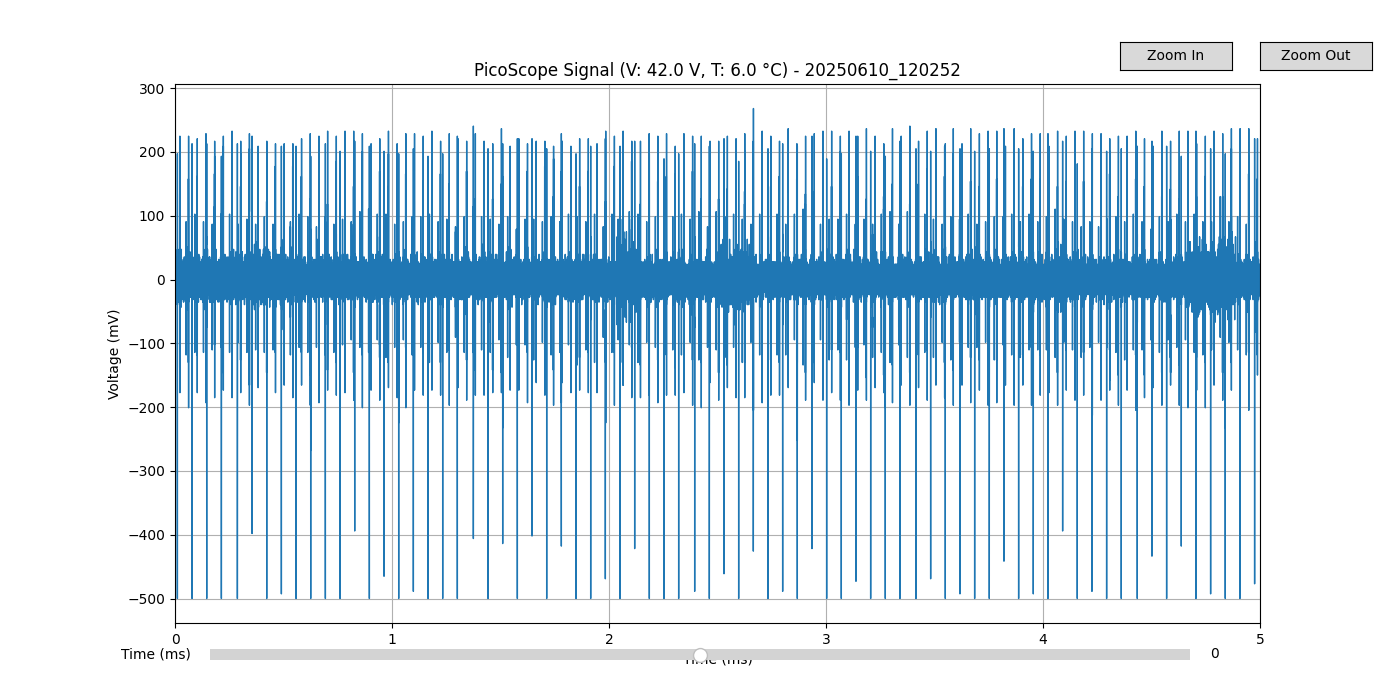

In [2]:
# Cell 1: Essential for interactive plots in Jupyter
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import json
from matplotlib.widgets import Slider, Button
import glob

# --- Copy/Paste the load_picoscope_data function here ---
def load_picoscope_data(base_filepath):
    """
    Loads PicoScope signal data from .npy and associated metadata from .json.
    `base_filepath` should be like 'path/to/picoscope_signal_YYYYMMDD_HHMMSS'.
    """
    data_filepath = f"{base_filepath}.npy"
    metadata_filepath = f"{base_filepath}_metadata.json"

    if not os.path.exists(data_filepath):
        print(f"Error: Data file not found at {data_filepath}")
        return None, None, None # Return None for metadata too

    if not os.path.exists(metadata_filepath):
        print(f"Warning: Metadata file not found at {metadata_filepath}. Proceeding with data only.")
        metadata = {} # Empty metadata if not found
    else:
        with open(metadata_filepath, 'r') as f:
            metadata = json.load(f)

    data = np.load(data_filepath)
    time_data_s = data[:, 0]
    voltage_data_mv = data[:, 1]

    print(f"Loaded data from: {data_filepath}")
    if metadata:
        print(f"Loaded metadata from: {metadata_filepath}")
        print(f"  Applied Voltage: {metadata.get('applied_voltage_V', 'N/A')} V")
        print(f"  Temperature: {metadata.get('temperature_celsius', 'N/A')} °C")
    
    return time_data_s, voltage_data_mv, metadata

# --- Copy/Paste the plot_scrollable_signal function here ---
def plot_scrollable_signal(time_s, voltage_mv, metadata=None):
    """
    Plots the PicoScope signal with a scrollable and zoomable x-axis.
    """
    time_ms = time_s * 1e3 # Convert to milliseconds for plotting

    fig, ax = plt.subplots(figsize=(14, 7))
    line, = ax.plot(time_ms, voltage_mv, lw=1)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Voltage (mV)')
    
    title_str = "PicoScope Signal"
    if metadata:
        voltage_val = metadata.get('applied_voltage_V', 'N/A')
        temp_val = metadata.get('temperature_celsius', 'N/A')
        title_str = f"PicoScope Signal (V: {voltage_val} V, T: {temp_val} °C)"
        if 'timestamp' in metadata:
            title_str += f" - {metadata['timestamp']}"
    ax.set_title(title_str)
    ax.grid(True)

    # Set initial view to a small window or the full range
    initial_window_ms = min(time_ms[-1], 100) # Show 100ms or less if signal is shorter
    ax.set_xlim(0, initial_window_ms)

    # Create a Slider for scrolling
    axcolor = 'lightgoldenrodyellow'
    # Adjust position to leave space for the plot itself and other widgets
    ax_slider = plt.axes([0.15, 0.05, 0.7, 0.03], facecolor=axcolor)
    
    slider_max = time_ms[-1] - (ax.get_xlim()[1] - ax.get_xlim()[0])
    if slider_max < 0:
        slider_max = 0

    s_time = Slider(ax_slider, 'Time (ms)', 0, slider_max, valinit=0)

    def update(val):
        start_time = s_time.val
        # Ensure the window size remains constant when scrolling
        current_window_size = ax.get_xlim()[1] - ax.get_xlim()[0]
        end_time = start_time + current_window_size
        ax.set_xlim(start_time, end_time)
        fig.canvas.draw_idle()

    s_time.on_changed(update)

    # Zoom in/out buttons
    ax_zoom_in = plt.axes([0.8, 0.9, 0.08, 0.04])
    ax_zoom_out = plt.axes([0.9, 0.9, 0.08, 0.04])
    
    button_zoom_in = Button(ax_zoom_in, 'Zoom In')
    button_zoom_out = Button(ax_zoom_out, 'Zoom Out')

    def zoom_in(event):
        current_xlim = ax.get_xlim()
        new_width = (current_xlim[1] - current_xlim[0]) * 0.8
        center = (current_xlim[0] + current_xlim[1]) / 2
        
        # Ensure new_width doesn't go below a reasonable minimum (e.g., 1ms)
        min_width = 1.0 # Adjust as needed
        if new_width < min_width:
            new_width = min_width

        ax.set_xlim(center - new_width/2, center + new_width/2)
        
        # Update slider max value based on new zoom level
        current_window_size = ax.get_xlim()[1] - ax.get_xlim()[0]
        s_time.set_max(max(0, time_ms[-1] - current_window_size))
        # Adjust slider position to stay within bounds
        s_time.set_val(max(0, min(s_time.val, time_ms[-1] - current_window_size)))
        
        fig.canvas.draw_idle()

    def zoom_out(event):
        current_xlim = ax.get_xlim()
        new_width = (current_xlim[1] - current_xlim[0]) * 1.2
        
        max_total_width = time_ms[-1] - time_ms[0]
        if new_width > max_total_width:
            new_width = max_total_width
        
        center = (current_xlim[0] + current_xlim[1]) / 2
        ax.set_xlim(center - new_width/2, center + new_width/2)
        
        # Update slider max value based on new zoom level
        current_window_size = ax.get_xlim()[1] - ax.get_xlim()[0]
        s_time.set_max(max(0, time_ms[-1] - current_window_size))
        # Adjust slider position to stay within bounds
        s_time.set_val(max(0, min(s_time.val, time_ms[-1] - current_window_size)))
        
        fig.canvas.draw_idle()

    button_zoom_in.on_clicked(zoom_in)
    button_zoom_out.on_clicked(zoom_out)
    
    plt.show() # Still call show in Jupyter for initial display

# Cell 2: Run the main plotting logic
data_folder = "picoscope_recordings"
    
all_data_files = glob.glob(os.path.join(data_folder, "*.npy"))

if not all_data_files:
    print(f"No .npy signal data files found in '{data_folder}'.")
    print("Please ensure you have run the PicoScope recorder script first.")
else:
    print("Available recordings:")
    all_data_files.sort(key=os.path.getmtime, reverse=True)
    
    file_options = []
    for i, filepath in enumerate(all_data_files):
        base_name = os.path.splitext(os.path.basename(filepath))[0]
        base_name = base_name.replace('_metadata', '')
        if base_name not in [opt[0] for opt in file_options]:
            file_options.append((base_name, filepath.replace('.npy', '')))
            print(f"  {len(file_options)-1}: {base_name}")

    if file_options:
        while True:
            try:
                choice = input(f"Enter the number of the recording to plot (0-{len(file_options)-1}), or 'q' to quit: ")
                if choice.lower() == 'q':
                    break
                
                choice_idx = int(choice)
                if 0 <= choice_idx < len(file_options):
                    selected_base_filepath = file_options[choice_idx][1]
                    time_data, voltage_data, metadata = load_picoscope_data(selected_base_filepath)
                    if time_data is not None and voltage_data is not None:
                        plot_scrollable_signal(time_data, voltage_data, metadata)
                    else:
                        print("Failed to load selected data.")
                else:
                    print("Invalid choice. Please enter a valid number.")
            except ValueError:
                print("Invalid input. Please enter a number or 'q'.")
            except Exception as e:
                print(f"An error occurred: {e}")
    else:
        print("No unique recordings found to plot.")

In [1]:
import ctypes
import numpy as np
from picosdk.ps2000a import ps2000a as ps
import matplotlib.pyplot as plt
from picosdk.functions import adc2mV, assert_pico_ok
import time
import os
import json # For saving metadata
import serial # For PLH120P power supply control
import datetime # For more precise timestamps

# --- Configuration for Data Saving ---
OUTPUT_FOLDER = "picoscope_SiPM_measurements_50C"
# Ensure the output directory exists before any file operations
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    print(f"Created folder: {OUTPUT_FOLDER}")

# --- PicoScope Functions (Provided by you, slightly adapted for automation) ---

def check_picoscope_connection():
    """Checks if a PicoScope 2000A device can be opened."""
    chandle = ctypes.c_int16()
    try:
        status = ps.ps2000aOpenUnit(ctypes.byref(chandle), None)
        assert_pico_ok(status) # This will raise an error if connection fails
        print("PicoScope 2000A device connected successfully.")
        return chandle
    except Exception as e:
        print(f"Error connecting to PicoScope 2000A: {e}")
        return None

def setup_picoscope_channel(chandle, channel, enabled, coupling, range_mv, offset_v=0.0):
    """Sets up a PicoScope channel and returns the actual range used."""
    range_code = None
    ranges_mv = {
        10: ps.PS2000A_RANGE['PS2000A_10MV'], 20: ps.PS2000A_RANGE['PS2000A_20MV'],
        50: ps.PS2000A_RANGE['PS2000A_50MV'], 100: ps.PS2000A_RANGE['PS2000A_100MV'],
        200: ps.PS2000A_RANGE['PS2000A_200MV'], 500: ps.PS2000A_RANGE['PS2000A_500MV'],
        1000: ps.PS2000A_RANGE['PS2000A_1V'], 2000: ps.PS2000A_RANGE['PS2000A_2V'],
        5000: ps.PS2000A_RANGE['PS2000A_5V'], 10000: ps.PS2000A_RANGE['PS2000A_10V'],
        20000: ps.PS2000A_RANGE['PS2000A_20V']
    }
    if range_mv in ranges_mv:
        range_code = ranges_mv[range_mv]
    else:
        print(f"Warning: {range_mv} mV range not directly supported. Using closest available.")
        closest_range = min(ranges_mv.keys(), key=lambda x: abs(x - range_mv))
        range_code = ranges_mv[closest_range]
        range_mv = closest_range
        print(f"Using {range_mv} mV range (code: {range_code}).")

    status = ps.ps2000aSetChannel(chandle,
                                    channel,
                                    enabled,
                                    coupling,
                                    range_code,
                                    offset_v)
    assert_pico_ok(status)
    return range_code, range_mv

def acquire_picoscope_block_data(chandle, num_samples, timebase):
    """Acquires a block of data from the PicoScope."""
    buffer_max = (ctypes.c_int16 * num_samples)()
    buffer_min = (ctypes.c_int16 * num_samples)() # Even if not used, good practice to allocate
    channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']

    status_set_buffers = ps.ps2000aSetDataBuffers(chandle, channel_a, ctypes.byref(buffer_max), ctypes.byref(buffer_min), num_samples, 0, 0)
    assert_pico_ok(status_set_buffers)

    status_run_block = ps.ps2000aRunBlock(chandle, 0, num_samples, timebase, 0, None, 0, None, None)
    assert_pico_ok(status_run_block)

    ready = ctypes.c_int16(0)
    check = ctypes.c_int16(0)
    while ready.value == check.value:
        is_ready = ps.ps2000aIsReady(chandle, ctypes.byref(ready))
        if is_ready != 0:
            print(f"Error checking readiness: {is_ready}")
            break # Exit loop on error
        time.sleep(0.001)

    overflow = ctypes.c_int16()
    c_num_samples = ctypes.c_int32(num_samples)
    status_get_values = ps.ps2000aGetValues(chandle, 0, ctypes.byref(c_num_samples), 0, 0, 0, ctypes.byref(overflow))
    assert_pico_ok(status_get_values)

    return buffer_max

# --- PLH120P Power Supply Functions (Provided by you) ---

def connect_plh120p(port, baudrate=9600, timeout=2):
    """Connect to the PLH120P power supply."""
    try:
        ser = serial.Serial(port, baudrate, timeout=timeout)
        print(f"Connected to PLH120 P on port {port} with baudrate {baudrate}.")
        return ser
    except serial.SerialException as e:
        print(f"Error: {e}")
        print(
            f"Could not connect to PLH120 P on port {port}. Please ensure the device is "
            "connected, the port is correct, and no other program is using the port."
        )
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

def send_command(ser, command):
    """Send a command to the PLH120P."""
    if ser and ser.is_open:
        ser.write(f"{command}\r\n".encode("ascii"))
        time.sleep(0.05) # Small delay for command processing

def set_voltage_and_on(ser, voltage):
    """Set the voltage and turn the output on."""
    if ser:
        print(f"Setting PLH120P voltage to {voltage:.2f} V and turning ON output...")
        send_command(ser, f"V1 {voltage:.2f}")
        send_command(ser, "OP1 1")
        time.sleep(2) # Give some time for the voltage to settle and stabilize

def set_voltage(ser, voltage):
    """Sets the voltage of the power supply."""
    if ser:
        print(f"Adjusting PLH120P voltage to {voltage:.2f} V...")
        send_command(ser, f"V1 {voltage:.2f}")
        time.sleep(0.5)  # Give some time for the voltage to settle

def turn_off_output(ser):
    """Turn the output off."""
    if ser and ser.is_open:
        print("Turning PLH120P output OFF.")
        send_command(ser, "OP1 0")
        time.sleep(0.5)

def disconnect_plh120p(ser):
    """Disconnect from the PLH120P power supply."""
    if ser and ser.is_open:
        ser.close()
        print("Disconnected from PLH120P.")

# --- Main Automated Measurement Script ---

def automated_sipm_measurement():
    """
    Automates PicoScope measurements by varying applied voltage on a SiPM.
    Performs multiple measurements per voltage and saves data with metadata.
    """
    pico_handle = None
    plh_serial = None

    try:
        # --- 1. Connect Devices ---
        print("\n--- Connecting Devices ---")
        pico_handle = check_picoscope_connection()
        if pico_handle is None:
            print("PicoScope connection failed. Exiting.")
            return

        # *** IMPORTANT: CHANGE THIS TO YOUR PLH120P's COM PORT ***
        PLH120P_PORT = 'COM6' # e.g., 'COM4' on Windows, '/dev/ttyUSB0' on Linux
        plh_serial = connect_plh120p(PLH120P_PORT)
        if plh_serial is None:
            print("PLH120P connection failed. Exiting.")
            # Ensure PicoScope is closed if PLH fails
            if pico_handle and pico_handle.value > 0:
                ps.ps2000aCloseUnit(pico_handle)
            return

        # --- 2. Initial Setup for PicoScope ---
        channel_a = ps.PS2000A_CHANNEL['PS2000A_CHANNEL_A']
        pico_channel_enabled = 1
        pico_coupling = ps.PS2000A_COUPLING['PS2000A_DC']
        pico_voltage_range_mv = 1000 # Typical for SiPM signals, adjust if needed
        pico_channel_range_code, pico_actual_range_mv = setup_picoscope_channel(
            pico_handle, channel_a, pico_channel_enabled, pico_coupling, pico_voltage_range_mv
        )

        pico_timebase = 1 # Corresponds to 4 ns sampling interval (250 MS/s) for PS2000a if oversample=0
        pico_acquisition_duration_s = 0.05 # e.g., 0.5 ms acquisition duration (adjust as needed)

        # Get actual sampling interval based on timebase
        time_interval_ns = ctypes.c_float()
        returned_max_samples = ctypes.c_int32()
        oversample = ctypes.c_int16(0)
        status_tb = ps.ps2000aGetTimebase2(pico_handle, pico_timebase, 1, ctypes.byref(time_interval_ns), oversample, ctypes.byref(returned_max_samples), 0)
        assert_pico_ok(status_tb)
        pico_sampling_interval_s = time_interval_ns.value / 1e9
        
        pico_num_samples = int(pico_acquisition_duration_s / pico_sampling_interval_s)
        if pico_num_samples < 1:
            pico_num_samples = 1
        
        print(f"PicoScope configured for: {pico_sampling_interval_s * 1e9:.2f} ns/sample ({1/pico_sampling_interval_s / 1e6:.2f} MS/s), {pico_num_samples} samples per measurement.")

        # --- 3. Define Measurement Parameters ---
        # Voltage range for the SiPM
        start_voltage = 67
        end_voltage = 71
        voltage_step = 0.2 # or 1.0, 0.1, etc.
        num_measurements_per_voltage = 5 # How many times to record at each voltage

        voltages_to_test = np.arange(start_voltage, end_voltage + voltage_step, voltage_step)
        if len(voltages_to_test) == 0:
            print("No voltages to test in the specified range. Adjust start, end, or step.")
            return

        # --- 4. Initial Power Supply Voltage (Ramp up safely) ---
        initial_ramp_voltage = 65.0 # A safe voltage to turn on the output first
        set_voltage_and_on(plh_serial, initial_ramp_voltage)
        time.sleep(2) # Give it time to stabilize

        # --- 5. Main Measurement Loop ---
        print("\n--- Starting Automated Measurements ---")
        for current_voltage in voltages_to_test:
            set_voltage(plh_serial, current_voltage)
            time.sleep(0.5) # Wait for voltage to settle after adjustment

            for i in range(num_measurements_per_voltage):
                print(f"\nMeasuring at {current_voltage:.2f} V (Measurement {i+1}/{num_measurements_per_voltage})...")
                
                # Acquire data
                buffer_a_adc = acquire_picoscope_block_data(pico_handle, pico_num_samples, pico_timebase)
                
                maxADC = ctypes.c_int16()
                status_max_adc = ps.ps2000aMaximumValue(pico_handle, ctypes.byref(maxADC))
                assert_pico_ok(status_max_adc)

                voltage_data_mv = adc2mV(buffer_a_adc, pico_channel_range_code, maxADC)
                time_data_s = np.linspace(0, pico_acquisition_duration_s, pico_num_samples, endpoint=False) # endpoint=False to avoid off-by-one errors

                # --- Data Saving ---
                timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_%f")[:-3] # YYYYMMDD_HHMMSS_ms
                
                # Filename: Voltage_V[voltage]_Meas[index]_Timestamp.npy/json
                base_filename = f"V{current_voltage:.2f}V_M{i+1}_{timestamp_str}"
                data_filepath = os.path.join(OUTPUT_FOLDER, f"{base_filename}.npy")
                metadata_filepath = os.path.join(OUTPUT_FOLDER, f"{base_filename}_metadata.json")

                data_to_save = np.column_stack((time_data_s, voltage_data_mv))
                np.save(data_filepath, data_to_save)
                print(f"Signal data saved to: {data_filepath}")

                # Save metadata
                metadata = {
                    "timestamp": timestamp_str,
                    "applied_voltage_V": current_voltage,
                    "measurement_index": i + 1,
                    "acquisition_duration_s": pico_acquisition_duration_s,
                    "sampling_interval_s": pico_sampling_interval_s,
                    "num_samples": pico_num_samples,
                    "voltage_range_mV": pico_actual_range_mv,
                    "picoscope_unit": "PicoScope 2000A",
                    "channels_recorded": ["A"],
                    "power_supply_port": PLH120P_PORT,
                    "power_supply_type": "PLH120P",
                    # Consider adding temperature here if you have a sensor
                    # For now, it's manually entered or set to a placeholder
                    "temperature_celsius": 50.0 # Placeholder: Replace with actual reading if available
                }
                with open(metadata_filepath, 'w') as f:
                    json.dump(metadata, f, indent=4)
                print(f"Metadata saved to: {metadata_filepath}")



    except Exception as e:
        print(f"An error occurred during automated measurement: {e}")

    finally:
        print("\n--- Cleaning up devices ---")
        if plh_serial:
            turn_off_output(plh_serial)
            disconnect_plh120p(plh_serial)
        if pico_handle and pico_handle.value > 0: # Ensure handle is valid before closing
            status_close = ps.ps2000aCloseUnit(pico_handle)
            if status_close != 0:
                print(f"Warning: PicoScope close unit returned status {status_close}.")
            else:
                print("PicoScope unit closed.")
        print("Automated measurement complete.")

if __name__ == '__main__':
    automated_sipm_measurement()


--- Connecting Devices ---
PicoScope 2000A device connected successfully.
Connected to PLH120 P on port COM6 with baudrate 9600.
PicoScope configured for: 4.00 ns/sample (250.00 MS/s), 12500000 samples per measurement.
Setting PLH120P voltage to 65.00 V and turning ON output...

--- Starting Automated Measurements ---
Adjusting PLH120P voltage to 67.00 V...

Measuring at 67.00 V (Measurement 1/5)...
Signal data saved to: picoscope_SiPM_measurements_50C\V67.00V_M1_20250611_161503_710.npy
Metadata saved to: picoscope_SiPM_measurements_50C\V67.00V_M1_20250611_161503_710_metadata.json

Measuring at 67.00 V (Measurement 2/5)...
Signal data saved to: picoscope_SiPM_measurements_50C\V67.00V_M2_20250611_161507_916.npy
Metadata saved to: picoscope_SiPM_measurements_50C\V67.00V_M2_20250611_161507_916_metadata.json

Measuring at 67.00 V (Measurement 3/5)...
Signal data saved to: picoscope_SiPM_measurements_50C\V67.00V_M3_20250611_161511_973.npy
Metadata saved to: picoscope_SiPM_measurements_50C\

Analyzing data for 69.2V with prominence=10mV, distance=10 samples, polarity='positive'...
Found 9159991 total peak amplitudes for 69.2V.


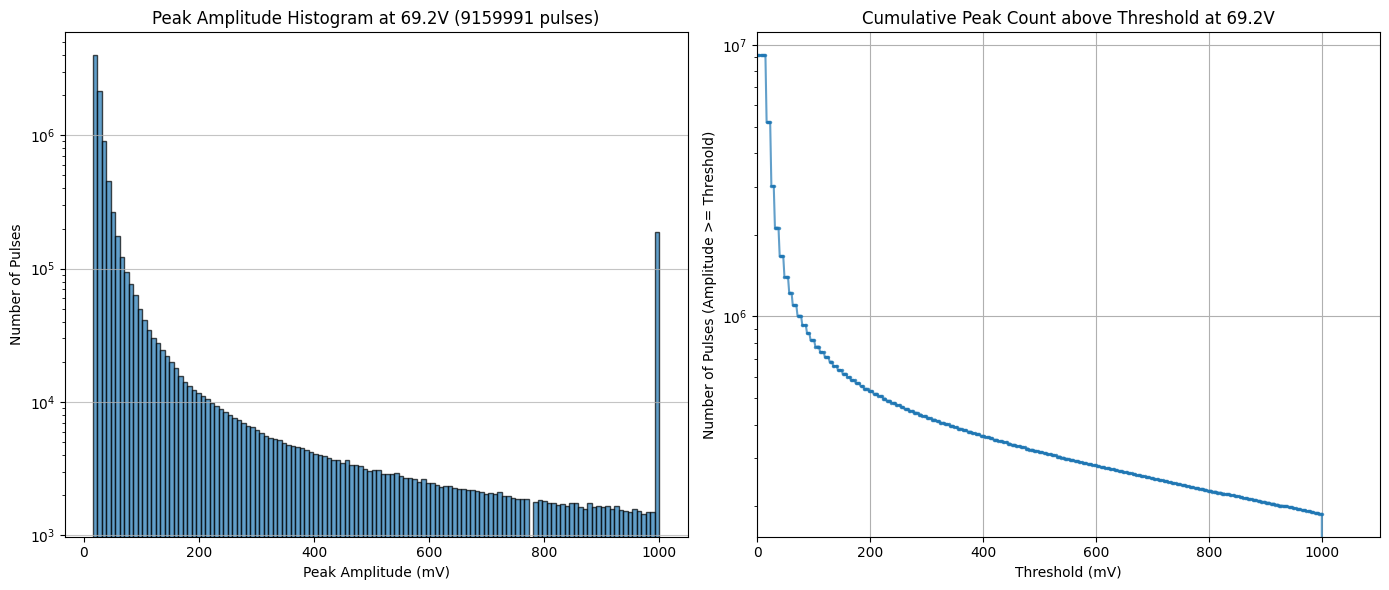

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy.signal import find_peaks

# --- Configuration (Keep these as they are for the script to run) ---
OUTPUT_FOLDER = "picoscope_SiPM_measurements_30C"
TARGET_VOLTAGE = 69.2 # Volts
PICO_BIT_RESOLUTION = 8 # PicoScope 8-bit resolution

def get_peak_amplitudes_for_voltage(target_voltage_V, output_folder, prominence_mv, distance_samples, pulse_polarity='positive'):
    """
    Extracts all peak amplitudes for a specific voltage from measurement files.
    """
    all_peak_amplitudes = []
    
    for filename in os.listdir(output_folder):
        if filename.endswith(".npy"):
            base_name = filename.replace(".npy", "")
            
            try:
                voltage_str_start = filename.find("V") + 1
                voltage_str_end = filename.find("V_", voltage_str_start)
                file_voltage = float(filename[voltage_str_start:voltage_str_end])
            except ValueError:
                continue

            if not np.isclose(file_voltage, target_voltage_V, atol=0.01):
                continue
            
            data_filepath = os.path.join(output_folder, filename)
            data = np.load(data_filepath)
            
            voltage_trace = data[:, 1]

            if pulse_polarity == 'negative':
                inverted_trace_for_peaks = -voltage_trace
                peaks, _ = find_peaks(inverted_trace_for_peaks, 
                                               height=prominence_mv, 
                                               prominence=prominence_mv,
                                               distance=distance_samples)
                amplitudes_mv = -voltage_trace[peaks] 
                
            elif pulse_polarity == 'positive':
                peaks, _ = find_peaks(voltage_trace,
                                               height=prominence_mv,
                                               prominence=prominence_mv,
                                               distance=distance_samples)
                amplitudes_mv = voltage_trace[peaks]
            else:
                raise ValueError("pulse_polarity must be 'negative' or 'positive'")

            if len(amplitudes_mv) > 0:
                all_peak_amplitudes.extend(amplitudes_mv)

    return np.array(all_peak_amplitudes)

def plot_amplitude_histograms(peak_amplitudes_mv, target_voltage_V, pico_bit_resolution, voltage_range_mv_for_bins):
    """
    Plots the peak amplitude histogram and the cumulative number of peaks ABOVE a threshold.
    """
    if len(peak_amplitudes_mv) == 0:
        print("No peak amplitudes to plot.")
        return

    # --- Histogram (Left Plot) ---
    bin_width_mv = (2 * voltage_range_mv_for_bins) / (2**pico_bit_resolution)
    
    # Ensure bins cover the range of amplitudes
    min_amp = np.floor(np.min(peak_amplitudes_mv) / bin_width_mv) * bin_width_mv
    max_amp = np.ceil(np.max(peak_amplitudes_mv) / bin_width_mv) * bin_width_mv
    
    # If max_amp - min_amp is too small, extend the range for better visualization
    if max_amp - min_amp < bin_width_mv:
        max_amp = min_amp + bin_width_mv * 5
        
    bins = np.arange(min_amp, max_amp + bin_width_mv, bin_width_mv)
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.yscale('log')
    plt.hist(peak_amplitudes_mv, bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Peak Amplitude (mV)')
    plt.ylabel('Number of Pulses')
    plt.title(f'Peak Amplitude Histogram at {target_voltage_V}V ({len(peak_amplitudes_mv)} pulses)')
    plt.grid(axis='y', alpha=0.75)
    
    # --- Cumulative Count ABOVE Threshold (Right Plot - the change is here) ---
    plt.subplot(1, 2, 2)
    
    # Sort amplitudes in ascending order
    sorted_amplitudes = np.sort(peak_amplitudes_mv)
    
    # Define thresholds for the cumulative plot
    # We want to go from 0 to 1000mV (or max_amp if it's lower)
    # Use a finer resolution for thresholds than the histogram bins for a smoother curve
    thresholds = np.linspace(0, np.max(sorted_amplitudes) * 1.05, 500) # Go slightly beyond max detected peak
    if np.max(sorted_amplitudes) < 1000: # Ensure plot goes up to 1000mV if relevant
        thresholds = np.linspace(0, 1000, 500) 
    
    cumulative_counts_above_threshold = []
    for threshold in thresholds:
        # Count how many peaks are greater than or equal to the current threshold
        count = np.sum(peak_amplitudes_mv >= threshold)
        cumulative_counts_above_threshold.append(count)

    plt.yscale('log') # Log scale is often useful for DCR
    plt.plot(thresholds, cumulative_counts_above_threshold, marker='.', linestyle='-', markersize=3, alpha=0.7)
    plt.xlabel('Threshold (mV)')
    plt.ylabel('Number of Pulses (Amplitude >= Threshold)')
    plt.title(f'Cumulative Peak Count above Threshold at {target_voltage_V}V')
    plt.grid(True)
    plt.xlim(left=0) # Ensure X-axis starts at 0

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # --- Determine Voltage Range from Metadata ---
    first_metadata_range_mv = None
    for filename in os.listdir(OUTPUT_FOLDER):
        if filename.startswith(f"V{TARGET_VOLTAGE:.2f}V_") and filename.endswith("_metadata.json"):
            metadata_filepath = os.path.join(OUTPUT_FOLDER, filename)
            with open(metadata_filepath, 'r') as f:
                metadata = json.load(f)
            first_metadata_range_mv = metadata.get('voltage_range_mV')
            if first_metadata_range_mv is not None:
                break
    
    if first_metadata_range_mv is None:
        print(f"Warning: Could not determine voltage range from metadata for {TARGET_VOLTAGE}V. Defaulting to 1000mV for histogram bin calculation.")
        first_metadata_range_mv = 1000

    # --- Peak Detection Parameters (Adjust these for accurate peak finding) ---
    # PEAK_DETECTION_PROMINENCE_MV should be significantly above your noise floor
    # PEAK_DETECTION_DISTANCE_SAMPLES should be larger than your typical pulse width in samples
    peak_detection_prominence_mv = 10 # Example: Adjust based on your signal-to-noise
    peak_detection_distance_samples = 10 # Example: Adjust based on your pulse width
    pulse_polarity_setting = 'positive' # Ensure this matches your actual pulse direction

    print(f"Analyzing data for {TARGET_VOLTAGE}V with prominence={peak_detection_prominence_mv}mV, distance={peak_detection_distance_samples} samples, polarity='{pulse_polarity_setting}'...")

    # --- Get Peak Amplitudes ---
    peak_amplitudes = get_peak_amplitudes_for_voltage(
        TARGET_VOLTAGE, 
        OUTPUT_FOLDER, 
        prominence_mv=peak_detection_prominence_mv,
        distance_samples=peak_detection_distance_samples,
        pulse_polarity=pulse_polarity_setting
    )

    # --- Plot Histograms ---
    if len(peak_amplitudes) > 0:
        print(f"Found {len(peak_amplitudes)} total peak amplitudes for {TARGET_VOLTAGE}V.")
        plot_amplitude_histograms(
            peak_amplitudes, 
            TARGET_VOLTAGE, 
            PICO_BIT_RESOLUTION, 
            first_metadata_range_mv
        )
    else:
        print(f"No peak amplitudes found for {TARGET_VOLTAGE}V with current settings.")
        print("Consider adjusting 'peak_detection_prominence_mv', 'peak_detection_distance_samples', or 'pulse_polarity'.")

--- Starting Dark Count Rate Analysis ---
Counting pulses above 250 mV as dark counts.
Initial peak detection: Prominence=50mV, Distance=50 samples.
Aggregating DCRs per voltage using MEDIAN.
Filtering individual DCR outliers: values beyond 2.0 standard deviations will be excluded.
Analyzing voltages in range: 60.0V to 80.0V.
Limiting to 10 files per voltage point for speed.

--- Processing data for Temperature: 50C (Folder: picoscope_SiPM_measurements_50C) ---
Starting DCR calculation for picoscope_SiPM_measurements_50C. Found 22 unique voltages in range [60.0, 80.0] to process...
[1/22] Processing 5 of max 10 files for 67.00V...
[2/22] Processing 5 of max 10 files for 67.20V...
[3/22] Processing 5 of max 10 files for 67.40V...
[4/22] Processing 5 of max 10 files for 67.60V...
[5/22] Processing 5 of max 10 files for 67.80V...
[6/22] Processing 5 of max 10 files for 68.00V...
[7/22] Processing 5 of max 10 files for 68.20V...
[8/22] Processing 5 of max 10 files for 68.40V...
[9/22] Proc

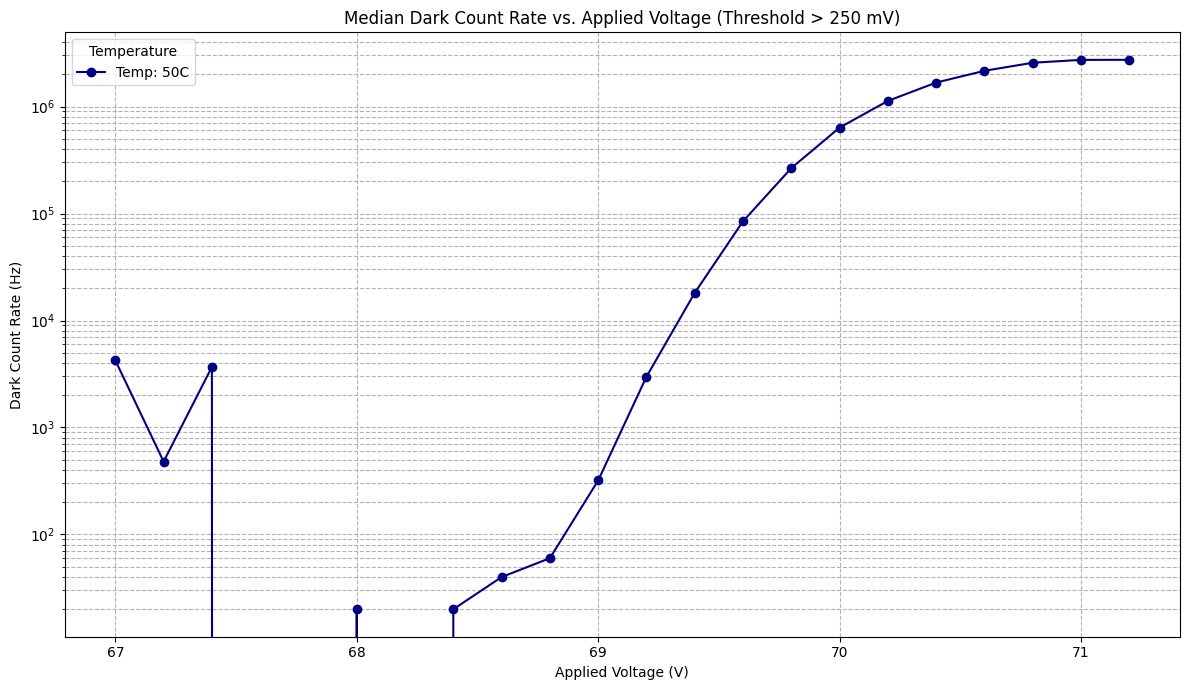


--- Saving all DCR data to JSON ---
All DCR data saved to: dcr_analysis_data\dcr_data_all_temperatures_threshold_250mV.json


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy.signal import find_peaks
import time

# --- Global Configuration Parameters ---
# List of folders containing data for different temperatures.
# IMPORTANT: Adjust these paths to match your actual data directory structure.
# For example, if you have data in 'data/temp_20C', 'data/temp_30C', etc.
TEMPERATURE_FOLDERS = [

    "picoscope_SiPM_measurements_50C"
]

# Voltage range to analyze (inclusive). Set to None to analyze all voltages found.
MIN_VOLTAGE_V = 60.0  # e.g., 60.0
MAX_VOLTAGE_V = 80.0  # e.g., 70.0

# Maximum number of .npy files to process per voltage step.
# Set to None or a very large number (e.g., 1000000) to process all available files.
MAX_FILES_PER_VOLTAGE = 10 # Set to a lower number for quick testing, increase for full analysis

# --- DCR Calculation Parameters ---
DCR_THRESHOLD_MV = 250
PEAK_DETECTION_PROMINENCE_MV = 50
PEAK_DETECTION_DISTANCE_SAMPLES = 50
PULSE_POLARITY = 'positive'

# --- Options for Robustness and Aggregation ---
USE_MEDIAN_DCR_FOR_VOLTAGE = True
FILTER_OUTLIERS_BEFORE_AGGREGATION = True
OUTLIER_STD_DEV_THRESHOLD = 2.0

# --- Output and Plotting Settings ---
SAVE_PLOTS = True
SAVE_DATA = True
PLOT_OUTPUT_DIR = "dcr_analysis_plots"
DATA_OUTPUT_DIR = "dcr_analysis_data"

def calculate_dcr_at_all_voltages(output_folder, dcr_threshold_mv,
                                  peak_prominence_mv, peak_distance_samples,
                                  pulse_polarity, use_median_dcr=False,
                                  filter_outliers=False, outlier_std_dev_threshold=3.0,
                                  min_voltage=None, max_voltage=None, max_files_per_voltage=None):
    """
    Calculates the Dark Count Rate (DCR) for each measured voltage within a specified range,
    with options for median calculation, outlier filtering, and limiting files processed.

    Args:
        output_folder (str): Directory where measurement files are stored.
        dcr_threshold_mv (float): The minimum peak amplitude (in mV) for a pulse
                                  to be counted as a dark count.
        peak_prominence_mv (float): Minimum prominence of peaks in mV.
        peak_distance_samples (int): Minimum horizontal distance (in samples) between adjacent peaks.
        pulse_polarity (str): 'negative' if pulses go downwards, 'positive' if upwards.
        use_median_dcr (bool): If True, calculates the median DCR for each voltage.
        filter_outliers (bool): If True, applies an outlier filter to individual
                                DCR measurements at each voltage before averaging/median.
        outlier_std_dev_threshold (float): Number of standard deviations from the mean
                                            to consider a DCR measurement an outlier.
        min_voltage (float, optional): Minimum voltage to include in analysis. Defaults to None (no minimum).
        max_voltage (float, optional): Maximum voltage to include in analysis. Defaults to None (no maximum).
        max_files_per_voltage (int, optional): Maximum number of .npy files to process per voltage.
                                                Defaults to None (process all files for that voltage).

    Returns:
        dict: A dictionary where keys are voltages (float) and values are
              their average/median DCR (counts/second).
    """
    voltage_data_raw_dcrs = {} # Stores lists of individual DCRs for each voltage

    # Group files by voltage first to apply max_files_per_voltage efficiently
    files_by_voltage = {}
    for filename in os.listdir(output_folder):
        if filename.endswith(".npy"):
            try:
                # Extract voltage from filename
                voltage_str_start = filename.find("V") + 1
                voltage_str_end = filename.find("V_", voltage_str_start)
                file_voltage = float(filename[voltage_str_start:voltage_str_end])

                # Apply voltage range filter
                if min_voltage is not None and file_voltage < min_voltage:
                    continue
                if max_voltage is not None and file_voltage > max_voltage:
                    continue

                if file_voltage not in files_by_voltage:
                    files_by_voltage[file_voltage] = []
                files_by_voltage[file_voltage].append(filename)
            except ValueError:
                print(f"Skipping {filename}: Could not parse voltage from filename.")
                continue

    total_voltages = len(files_by_voltage)
    print(f"Starting DCR calculation for {output_folder}. Found {total_voltages} unique voltages in range [{min_voltage if min_voltage is not None else 'min'}, {max_voltage if max_voltage is not None else 'max'}] to process...")
    start_time = time.time()

    processed_voltage_count = 0
    for file_voltage in sorted(files_by_voltage.keys()):
        processed_voltage_count += 1
        current_voltage_files = files_by_voltage[file_voltage]
        
        # Apply max_files_per_voltage limit
        if max_files_per_voltage is not None:
            current_voltage_files = current_voltage_files[:max_files_per_voltage]
            print(f"[{processed_voltage_count}/{total_voltages}] Processing {len(current_voltage_files)} of max {max_files_per_voltage} files for {file_voltage:.2f}V...")
        else:
            print(f"[{processed_voltage_count}/{total_voltages}] Processing all {len(current_voltage_files)} files for {file_voltage:.2f}V...")

        for filename in current_voltage_files:
            base_name = filename.replace(".npy", "")
            metadata_filepath = os.path.join(output_folder, f"{base_name}_metadata.json")

            if not os.path.exists(metadata_filepath):
                print(f"  Skipping {filename}: Metadata file not found.")
                continue

            with open(metadata_filepath, 'r') as f:
                metadata = json.load(f)

            acquisition_duration_s = metadata.get('acquisition_duration_s')
            if acquisition_duration_s is None or acquisition_duration_s <= 0:
                print(f"  Warning: Invalid 'acquisition_duration_s' ({acquisition_duration_s}) in metadata for {filename}. Skipping.")
                continue

            data_filepath = os.path.join(output_folder, filename)
            try:
                data = np.load(data_filepath)
            except Exception as e:
                print(f"  Error loading data from {data_filepath}: {e}. Skipping.")
                continue

            voltage_trace = data[:, 1]

            if pulse_polarity == 'negative':
                inverted_trace_for_peaks = -voltage_trace
                peaks, _ = find_peaks(inverted_trace_for_peaks,
                                               height=peak_prominence_mv,
                                               prominence=peak_prominence_mv,
                                               distance=peak_distance_samples)
                amplitudes_mv = -voltage_trace[peaks]

            elif pulse_polarity == 'positive':
                peaks, _ = find_peaks(voltage_trace,
                                               height=peak_prominence_mv,
                                               prominence=peak_prominence_mv,
                                               distance=peak_distance_samples)
                amplitudes_mv = voltage_trace[peaks]
            else:
                raise ValueError("pulse_polarity must be 'negative' or 'positive'")

            num_dark_counts = np.sum(amplitudes_mv >= dcr_threshold_mv)
            individual_dcr = num_dark_counts / acquisition_duration_s

            if file_voltage not in voltage_data_raw_dcrs:
                voltage_data_raw_dcrs[file_voltage] = []
            voltage_data_raw_dcrs[file_voltage].append(individual_dcr)
            # print(f"    Individual DCR: {individual_dcr:.2f} Hz. Dark counts: {num_dark_counts}") # Uncomment for verbose per-file DCR

    end_time = time.time()
    print(f"\nFinished processing all selected files in {end_time - start_time:.2f} seconds.")

    final_dcr_per_voltage = {}
    for voltage, dcr_list in voltage_data_raw_dcrs.items():
        if not dcr_list:
            final_dcr_per_voltage[voltage] = 0.0
            continue

        dcr_array = np.array(dcr_list)

        if filter_outliers:
            mean_dcr = np.mean(dcr_array)
            std_dcr = np.std(dcr_array)
            is_inlier = np.abs(dcr_array - mean_dcr) < (outlier_std_dev_threshold * std_dcr)
            filtered_dcrs = dcr_array[is_inlier]

            if len(filtered_dcrs) == 0:
                print(f"Warning: All DCR measurements for {voltage:.2f} V were filtered out as outliers. Setting DCR to 0.")
                final_dcr_per_voltage[voltage] = 0.0
                continue

            print(f"Voltage {voltage:.2f}V: Filtered {len(dcr_array) - len(filtered_dcrs)} outliers (out of {len(dcr_array)} measurements).")
            processing_array = filtered_dcrs
        else:
            processing_array = dcr_array

        if use_median_dcr:
            final_dcr_per_voltage[voltage] = np.median(processing_array)
            print(f"  Calculated median DCR for {voltage:.2f} V: {final_dcr_per_voltage[voltage]:.2f} Hz")
        else:
            final_dcr_per_voltage[voltage] = np.mean(processing_array)
            print(f"  Calculated average DCR for {voltage:.2f} V: {final_dcr_per_voltage[voltage]:.2f} Hz")

    return dict(sorted(final_dcr_per_voltage.items()))

def plot_dcr_all_temperatures(all_temp_dcr_data, dcr_threshold, calculation_method="Average", output_dir=None):
    """
    Plots the Dark Count Rate (DCR) vs. applied voltage for multiple temperatures
    on a single graph.

    Args:
        all_temp_dcr_data (dict): A dictionary where keys are temperature labels (str)
                                  and values are dictionaries of {voltage: DCR}.
        dcr_threshold (float): The threshold used for DCR calculation.
        calculation_method (str): "Average" or "Median" to be used in the plot title.
        output_dir (str, optional): Directory to save the plot. If None, plot is just shown.
    """
    if not all_temp_dcr_data:
        print("No DCR data to plot for any temperature.")
        return

    plt.figure(figsize=(12, 7))
    colors = plt.cm.jet(np.linspace(0, 1, len(all_temp_dcr_data))) # Use a colormap for distinct lines

    for i, (temp_label, dcr_data) in enumerate(all_temp_dcr_data.items()):
        if dcr_data:
            voltages = list(dcr_data.keys())
            dcrs = list(dcr_data.values())
            plt.plot(voltages, dcrs, marker='o', linestyle='-', color=colors[i], label=f'Temp: {temp_label}')
        else:
            print(f"No DCR data for {temp_label}.")

    plt.xlabel('Applied Voltage (V)')
    plt.ylabel('Dark Count Rate (Hz)')
    plt.title(f'{calculation_method} Dark Count Rate vs. Applied Voltage (Threshold > {dcr_threshold} mV)')
    plt.grid(True, which="both", ls="--", c='0.7') # Show grid for both major and minor ticks
    plt.yscale('log') # DCR often varies exponentially with voltage
    plt.legend(title="Temperature")
    plt.tight_layout()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plot_filename = os.path.join(output_dir, f"DCR_vs_Voltage_All_Temps_Threshold_{dcr_threshold}mV.png")
        plt.savefig(plot_filename, dpi=300)
        print(f"Plot saved to: {plot_filename}")
    plt.show()

def save_dcr_data_to_json(data_dict, dcr_threshold, output_dir="dcr_analysis_data"):
    """
    Saves the DCR data (voltage vs DCR) for all temperatures to a JSON file.

    Args:
        data_dict (dict): Dictionary with temperature labels as keys and DCR data (dict) as values.
        dcr_threshold (float): The DCR threshold used for the analysis.
        output_dir (str): Directory to save the JSON file.
    """
    os.makedirs(output_dir, exist_ok=True)
    filename = os.path.join(output_dir, f"dcr_data_all_temperatures_threshold_{dcr_threshold}mV.json")
    
    # Prepare data for saving: convert numpy arrays to lists for JSON compatibility
    savable_data = {
        temp_label: {str(v): dcr for v, dcr in dcr_results.items()}
        for temp_label, dcr_results in data_dict.items()
    }
    
    with open(filename, 'w') as f:
        json.dump(savable_data, f, indent=4)
    print(f"All DCR data saved to: {filename}")


if __name__ == '__main__':
    print("--- Starting Dark Count Rate Analysis ---")
    print(f"Counting pulses above {DCR_THRESHOLD_MV} mV as dark counts.")
    print(f"Initial peak detection: Prominence={PEAK_DETECTION_PROMINENCE_MV}mV, Distance={PEAK_DETECTION_DISTANCE_SAMPLES} samples.")

    if USE_MEDIAN_DCR_FOR_VOLTAGE:
        print("Aggregating DCRs per voltage using MEDIAN.")
        calculation_method_str = "Median"
    else:
        print("Aggregating DCRs per voltage using AVERAGE (Mean).")
        calculation_method_str = "Average"

    if FILTER_OUTLIERS_BEFORE_AGGREGATION:
        print(f"Filtering individual DCR outliers: values beyond {OUTLIER_STD_DEV_THRESHOLD} standard deviations will be excluded.")
    
    if MIN_VOLTAGE_V is not None or MAX_VOLTAGE_V is not None:
        print(f"Analyzing voltages in range: {MIN_VOLTAGE_V if MIN_VOLTAGE_V is not None else 'min'}V to {MAX_VOLTAGE_V if MAX_VOLTAGE_V is not None else 'max'}V.")
    
    if MAX_FILES_PER_VOLTAGE is not None:
        print(f"Limiting to {MAX_FILES_PER_VOLTAGE} files per voltage point for speed.")

    all_temperatures_dcr_results = {}

    for folder_path in TEMPERATURE_FOLDERS:
        if not os.path.isdir(folder_path):
            print(f"\nSkipping folder: '{folder_path}' - Directory not found.")
            continue
        
        # Extract temperature label from folder name (e.g., "30C" from "picoscope_SiPM_measurements_30C")
        # You might need to adjust this parsing based on your folder naming convention.
        try:
            temp_label = folder_path.split('_')[-1]
            if not temp_label.lower().endswith('c'): # Basic check to ensure it's a temp label
                temp_label = folder_path # Use full path if not a clear temp
        except:
            temp_label = folder_path # Fallback to full path
        
        print(f"\n--- Processing data for Temperature: {temp_label} (Folder: {folder_path}) ---")
        
        dcr_results = calculate_dcr_at_all_voltages(
            folder_path,
            dcr_threshold_mv=DCR_THRESHOLD_MV,
            peak_prominence_mv=PEAK_DETECTION_PROMINENCE_MV,
            peak_distance_samples=PEAK_DETECTION_DISTANCE_SAMPLES,
            pulse_polarity=PULSE_POLARITY,
            use_median_dcr=USE_MEDIAN_DCR_FOR_VOLTAGE,
            filter_outliers=FILTER_OUTLIERS_BEFORE_AGGREGATION,
            outlier_std_dev_threshold=OUTLIER_STD_DEV_THRESHOLD,
            min_voltage=MIN_VOLTAGE_V,
            max_voltage=MAX_VOLTAGE_V,
            max_files_per_voltage=MAX_FILES_PER_VOLTAGE
        )

        if dcr_results:
            print(f"\n--- DCR Results for {temp_label} ---")
            for voltage, dcr in dcr_results.items():
                print(f"Voltage: {voltage:.2f} V, Final DCR: {dcr:.2f} Hz")
            all_temperatures_dcr_results[temp_label] = dcr_results
        else:
            print(f"No DCR data calculated for {temp_label}. Check folder path and parameters.")

    # --- Plotting All Temperatures ---
    if all_temperatures_dcr_results:
        print("\n--- Generating combined DCR plot for all temperatures ---")
        plot_dcr_all_temperatures(
            all_temperatures_dcr_results,
            DCR_THRESHOLD_MV,
            calculation_method=calculation_method_str,
            output_dir=PLOT_OUTPUT_DIR if SAVE_PLOTS else None
        )
    else:
        print("\nNo data processed for any temperature. Skipping combined plot.")

    # --- Saving All Temperature Data ---
    if all_temperatures_dcr_results and SAVE_DATA:
        print("\n--- Saving all DCR data to JSON ---")
        save_dcr_data_to_json(all_temperatures_dcr_results, DCR_THRESHOLD_MV, DATA_OUTPUT_DIR)
    elif not all_temperatures_dcr_results:
        print("\nNo DCR data to save.")
    elif not SAVE_DATA:
        print("\nSkipping data save as SAVE_DATA is False.")

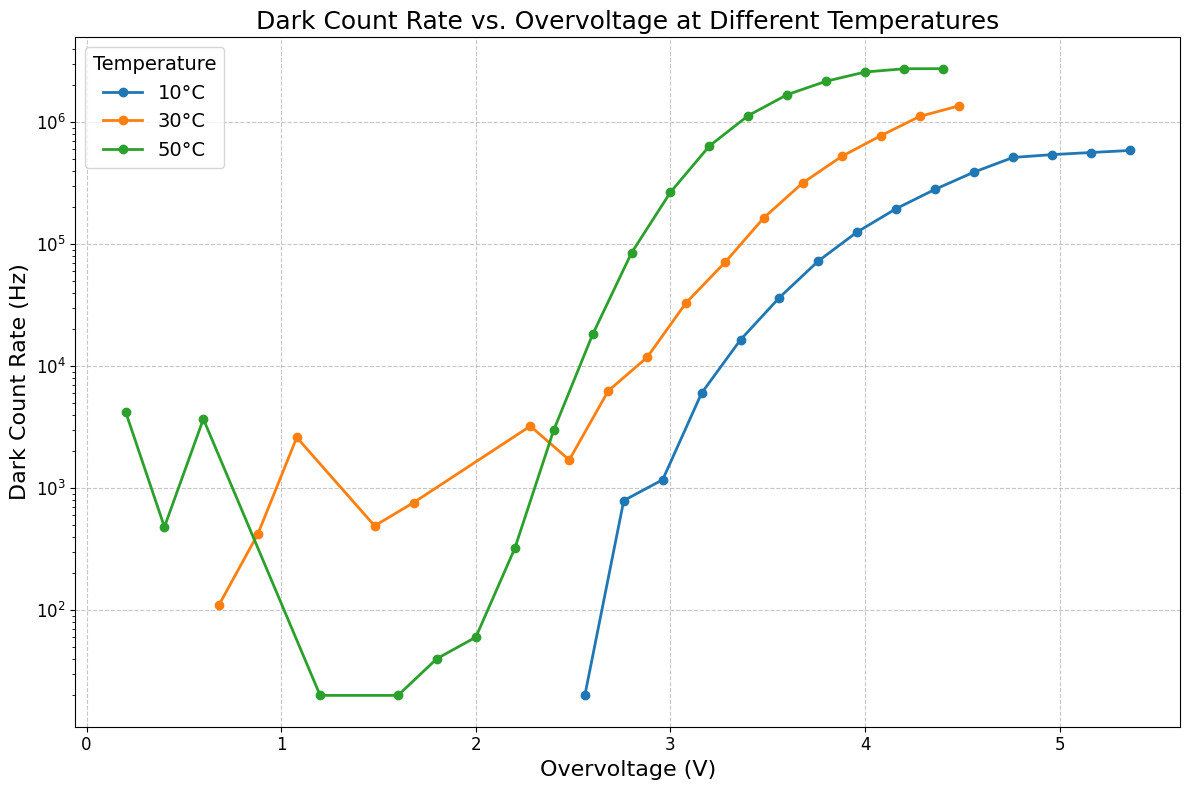

Plot saved to: DCR_Overvoltage_Plots\DCR_vs_Overvoltage_All_Temps.png


<Figure size 640x480 with 0 Axes>

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_dcr_vs_overvoltage_from_files(base_path, temperatures, output_dir=None):
    """
    Plots Dark Count Rate (DCR) vs. Overvoltage for specified temperatures
    from JSON files, all on one plot.

    Args:
        base_path (str): The base directory and file prefix (e.g., "C:\\Users\\DBouc\\Desktop\\Thesis\\dcr_analysis_data\\dcr_data_all_temperatures_threshold_250mV_").
        temperatures (list): A list of integer temperatures (e.g., [10, 30, 50]).
        output_dir (str, optional): Directory to save the plot. If None, plots are only shown.
    """

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(12, 8))

    # --- Constants for Overvoltage Calculation ---
    # Overvoltage = Bias_Voltage - (63 - 0.074 * Temperature)
    V_BD_ref = 63.1
    temp_coefficient = 0.074 # V/C

    for temp in sorted(temperatures): # Sort by temperature for consistent plotting order
        # Construct the full file path for the current temperature
        filepath = f"{base_path}{temp}C.json"

        if not os.path.exists(filepath):
            print(f"Error: File not found at '{filepath}'. Skipping {temp}°C data.")
            continue
        
        try:
            with open(filepath, 'r') as f:
                data = json.load(f)

            # Dynamically find the top-level key that contains the data for this temperature
            # (e.g., "50C" for temp=50)
            temp_key_in_json = None
            for k in data.keys():
                if str(temp) in k:
                    temp_key_in_json = k
                    break
            
            if not temp_key_in_json:
                print(f"Warning: Data for temperature {temp}°C not found under expected key in '{filepath}'. Skipping.")
                continue

            bias_voltages_str = list(data[temp_key_in_json].keys())
            dcr_values_raw = list(data[temp_key_in_json].values())

            # Convert bias voltages from string to float
            bias_voltages = np.array([float(v) for v in bias_voltages_str])
            dcr_values = np.array(dcr_values_raw)

            # Calculate V_BD for the current temperature
            v_bd_at_temp = V_BD_ref + (temp_coefficient * temp)

            # Calculate Overvoltage
            overvoltages = bias_voltages - v_bd_at_temp

            # --- Plotting ---
            # Filter out DCR values that are 0 or less for a logarithmic plot
            # If a DCR value is 0, it cannot be plotted on a log scale.
            positive_dcr_indices = dcr_values > 0
            overvoltages_filtered = overvoltages[positive_dcr_indices]
            dcr_values_filtered = dcr_values[positive_dcr_indices]

            if len(dcr_values_filtered) > 0:
                plt.semilogy(overvoltages_filtered, dcr_values_filtered,
                             marker='o', linestyle='-',
                             label=f'{temp}°C', linewidth=2)
            else:
                print(f"Warning: No positive DCR values found to plot for {temp}°C from '{filepath}'.")

        except json.JSONDecodeError as e:
            print(f"Error reading JSON from '{filepath}': {e}")
            continue
        except Exception as e:
            print(f"An unexpected error occurred processing '{filepath}': {e}")
            continue

    # --- Final Plot Customization ---
    plt.xlabel('Overvoltage (V)', fontsize=16)
    plt.ylabel('Dark Count Rate (Hz)', fontsize=16)
    plt.title('Dark Count Rate vs. Overvoltage at Different Temperatures', fontsize=18)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Temperature', fontsize=14, title_fontsize='14')
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

    if output_dir:
        plot_filename = os.path.join(output_dir, "DCR_vs_Overvoltage_All_Temps.png")
        plt.savefig(plot_filename, dpi=300)
        print(f"Plot saved to: {plot_filename}")


if __name__ == "__main__":
    # --- Configuration ---
    # This is the common part of your file path, excluding the temperature and ".json"
    base_file_path = r"C:\Users\DBouc\Desktop\Thesis\dcr_analysis_data\dcr_data_all_temperatures_threshold_250mV_"

    # List of temperatures you want to plot
    temperatures_to_plot = [10, 30, 50]

    # Optional: Directory to save the plot.
    # If set to None, the plot will only be displayed and not saved.
    plots_output_directory = "DCR_Overvoltage_Plots"
    # plots_output_directory = None # Uncomment this line if you don't want to save the plot

    # --- Run the plotting function ---
    plot_dcr_vs_overvoltage_from_files(base_file_path, temperatures_to_plot, output_dir=plots_output_directory)